# 1D linearized shallow-water equation with wind stress

The one-dimensional shallow-water equations can be simplified to a 1D wave-equation with wind forcing:

$\partial h/\partial t + \partial Hu / \partial x = 0$

$\partial u/\partial t + g \partial h / \partial x = \tau/(\rho H) -(\rho g u|u|)/(H C^2)$

where $h$ denotes the water-height above the reference, $u$ the velocity, $D$ the depth below the reference, $H=D+h$ the total water depth and $t,x$ time and space. In the quadratic friction term $C$ denotes the Chezy friction coefficient.

At the left boundary $q_{left}$ denotes the inflow and $q_{right}$ the outflow at the right boundary, i.e. the sign is aligned with $u$.

$u(x=0,t)=q_{left}(t)/(H W)$

$u(x=L,t)=q_{right}(t)/(H W)$

The equations and approach are similar to the model_1d_wave_periodic.jl 
model. Here the equations are not fully linear, on a 'closed' domain,
and with a wind-stress forcing term.


In [1]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2


  Activating project at `~/dellete/src/julia_ml_tests.jl.git/model_1d`


In [2]:
# Load model definition
include("../model_1d/model_1d_surge_wave.jl")

Wave1DSurge_cpu

In [3]:
# setting up the problem
# parameters
nx=100     # number of spatial points
L=100.0e3  # length of the domain
dx=L/nx    # spatial step
rho=1000.0 # density of water
g=10.0     # acceleration due to gravity
grid_u=collect(0.0:dx:L) # grid for velocity
grid_h=collect(dx/2:dx:(L-dx/2)) # grid for water levels
D_min=10.0 # minimum depth of the water
D_max=30.0 # maximum depth of the water
D_edges=[0.3,0.7] .* L # edges of the depth change
D_widths=[0.05,0.05] .* L # widths of the depth change
D=depth_profile(grid_u,D_min,D_max,D_edges,D_widths)
W=100.0 # width
C=60.0 # Chezy friction factor

# wind stress as a function of time
# wind stress forcing
function tau_func(t,a=1.0,T=3600.0)
    return (a*sin(2*π*t/T))^2
end
tau(t)=tau_func(t,1.0,8*3600.0) # set parameters

function constant_func(t,value=0.0)
    return value
end
q_left(t)=constant_func(t,100.0)
q_right(t)=constant_func(t,50.0) #Note q_left-q_right is the nett influx

# initial state
f=Wave1DSurge_cpu(g,D,L,W,dx,nx,rho,C,tau,q_left,q_right)
x0=initial_state_bump(f,0.25,0.05,0.3,0.0) # h bump
#x0=initial_state_bump(f,0.0,0.05,0.3,0.1) # u bump


# time span
t_start=0.0
t_end=6*3600.0 # hours

# spatial grid 
x_h = grid_h
x_u = grid_u
x=ComponentVector(h=x_h,u=x_u)

ComponentVector{Float64}(h = [500.0, 1500.0, 2500.0, 3500.0, 4500.0, 5500.0, 6500.0, 7500.0, 8500.0, 9500.0  …  90500.0, 91500.0, 92500.0, 93500.0, 94500.0, 95500.0, 96500.0, 97500.0, 98500.0, 99500.0], u = [0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0  …  91000.0, 92000.0, 93000.0, 94000.0, 95000.0, 96000.0, 97000.0, 98000.0, 99000.0, 100000.0])

In [4]:
# # test steps of the pde model
# h_avg=similar(x0.u)
# avg_h!(h_avg,x0.h,dx)
# #@show h_avg[1:10:end]'
# H=h_avg .+ D
# @show H[1:10:end]'
# Hu=H .* x0.u
# @show x0.u[1:10:end]'
# @show Hu[1:10:end]'

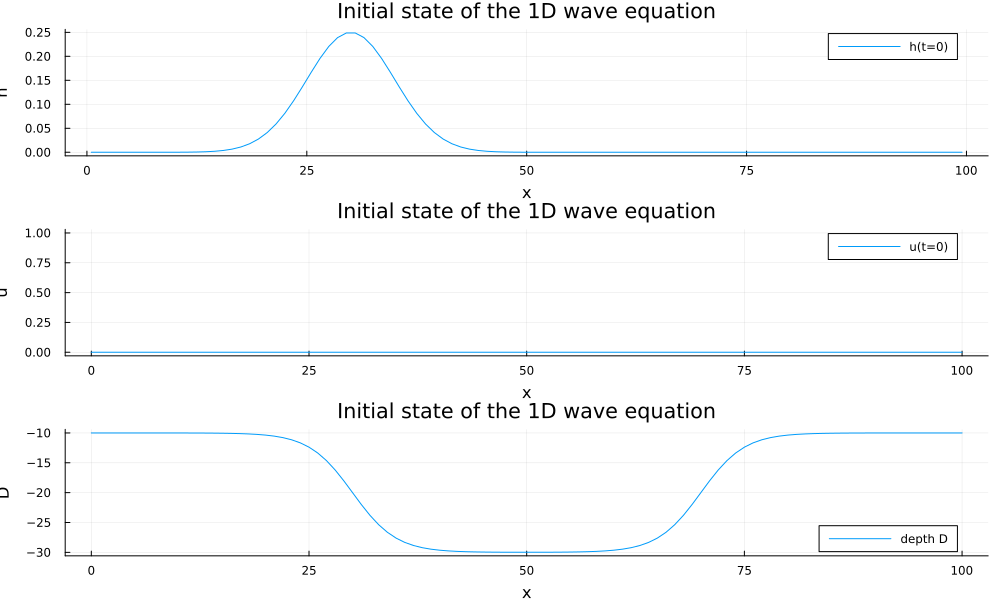

In [5]:
# plot the initial state
p1=plot(1e-3*x_h, x0.h, label="h(t=0)", xlabel="x", ylabel="h")
p2=plot(1e-3*x_u, x0.u, label="u(t=0)", xlabel="x", ylabel="u")
p3=plot(1e-3*x_u, -D, label="depth D", xlabel="x", ylabel="D")
plot(p1, p2, p3, layout=(3,1), size=(1000,600),title="Initial state of the 1D wave equation")

size(dx_dt.h) = (100,)
size(dx_dt.u) = (101,)


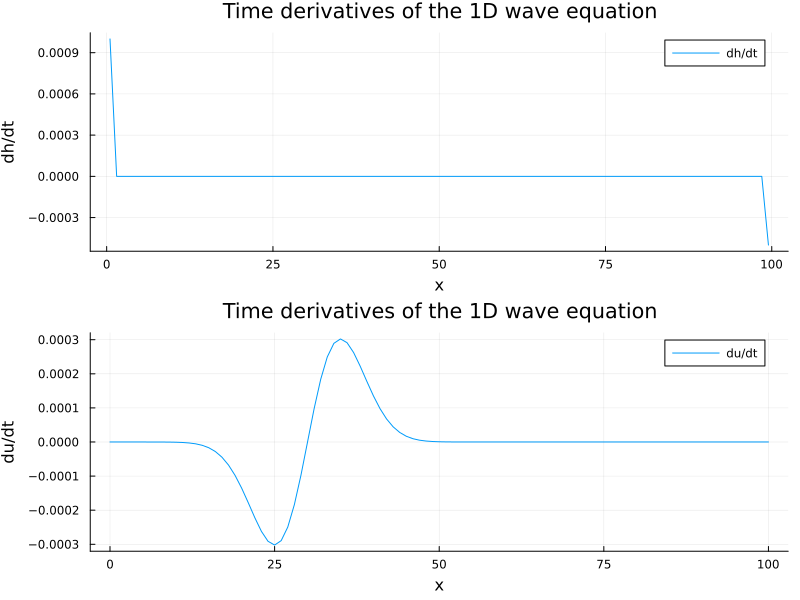

In [ ]:
# # check model components 
# dx_dt=similar(x0)
# f(dx_dt,x0,f,t_start)
# @show size(dx_dt.h)
# @show size(dx_dt.u)
# p1=plot(1e-3*x_h, dx_dt.h, label="dh/dt", xlabel="x", ylabel="dh/dt")
# p2=plot(1e-3*x_u, dx_dt.u, label="du/dt", xlabel="x", ylabel="du/dt")
# plot(p1, p2, layout=(2,1), size=(800,600), title="Time derivatives of the 1D wave equation")

In [7]:
prob = ODEProblem(f, x0, (t_start, t_end))
@time sol = solve(prob, Tsit5(),saveat=10.0) # with timing, but ouput only at t=10.0
sol = solve(prob, Tsit5()) # store output, no timing

nothing

  3.028826 seconds (7.80 M allocations: 432.619 MiB, 4.63% gc time, 99.84% compilation time)


┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/wave1d_surge.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/uiCPf/src/animation.jl:156


 25.077241 seconds (8.69 M allocations: 449.024 MiB, 1.94% gc time, 3.42% compilation time: 9% of which was recompilation)


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/wave1d_surge.gif")
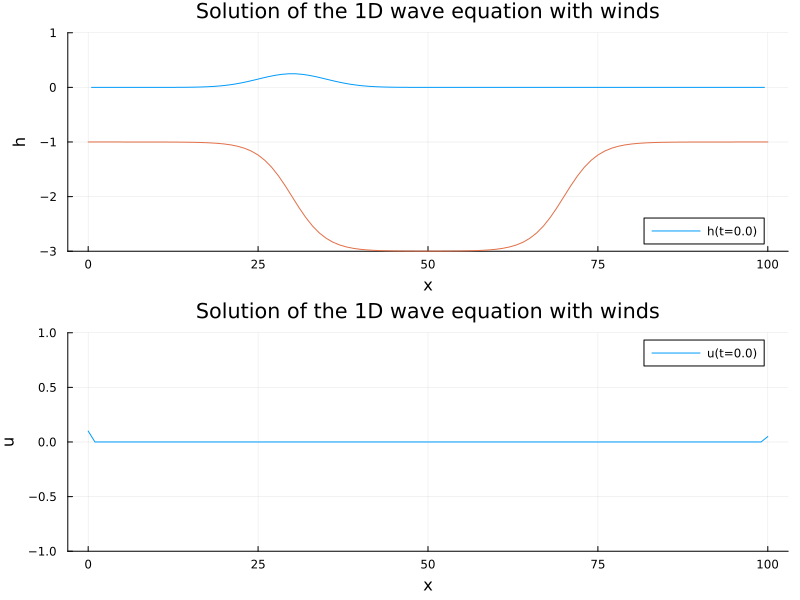

In [8]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(1e-3*x_h, sol[i].h, label="h(t=$(round(sol.t[i]/3600,digits=1)))", xlabel="x", ylabel="h", ylim=(-3, 1))
        plot!(p1,1e-3*x_u,-0.1*f.D,label=false) #depth with false scaling
        p2 = plot(1e-3*x_u, sol[i].u, label="u(t=$(round(sol.t[i]/3600,digits=1)))", xlabel="x", ylabel="u", ylim=(-1, 1))
        plot(p1, p2, layout=(2,1), size=(800,600), title="Solution of the 1D wave equation with winds")
    end
    gif(anim, "wave1d_surge.gif", fps=30)
end


In [ ]:
# save the solution to a JLD2 file
cfl_out=1.0 # CFL number for output
dt_out_auto=cfl_out*f.dx/(sqrt(maximum(f.D)*f.g)) # time step for output, based on CFL condition
println("time-step with CFL=1 is $(dt_out_auto)")
dt_out=60.0 #manual value
times=collect(0.0:dt_out:t_end) # output times
solution=[]
for t in times
    h_value=sol(t).h
    u_value=sol(t).u
    tau_value=f.tau(t)
    q_left_value=f.q_left(t)
    q_right_value=f.q_right(t)
    x=ComponentVector(h=h_value,u=u_value,tau=tau_value,q_left=q_left_value,
        q_right=q_right_value)
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("wave1d_surge.jld2", 
    "solution", solution,
    "times", times,
    "params", (g=f.g, C=f.C, rho=f.rho, W=f.W, D=f.D, L=f.L, 
        dx=f.dx, nx=f.nx),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D shallow water equation with wind stress.")


In [11]:
# load the solution from the JLD2 file for testing
ff=load("wave1d_surge.jld2")

@show ff["solution"][1].h[1:20:end] # show some values of the initial height field
display(ff["solution"])


375-element Vector{Any}:
 ComponentVector{Float64}(h = [6.903106142070087e-9, 2.2020447991151393e-8, 6.748946258407535e-8, 1.9873484038372852e-7, 5.622639917580856e-7, 1.5283919915928505e-6, 3.991695974451187e-6, 1.0016324348237767e-5, 2.4148353430546002e-5, 5.593644843015514e-5  …  4.030996870125581e-33, 3.513451194407281e-34, 2.9422773598041807e-35, 2.3673447931789788e-36, 1.8300697477649765e-37, 1.359258285483071e-38, 9.699839690710992e-40, 6.650516039859967e-41, 4.381011109346297e-42, 2.7728194031375702e-43], u = [0.09999877111128867, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.049999385590159005])
 ComponentVector{Float64}(h = [0.054636603598340154, 0.003059390451575719, 5.16079586263078e-5, 6.484276932805023e-7, 6.670309507874284e-7, 1.7835359433665516e-6, 4.5972367609597605e-6, 1.1391991181185134e-5, 2.7138595799549982e-5, 6.215251473518751e-5  …  3.237386947977943e-23, 5.339320624072769e-22, -2.7213150980729368e-18, -3.74480754

((ff["solution"])[1]).h[1:20:end] = [6.903106142070087e-9, 0.041118614144288725, 0.027562631326121304, 2.079175614207083e-9, 1.7650213343156265e-23]


In [12]:
ff["times"]

375-element Vector{Float64}:
     0.0
    57.74793888169217
   115.49587776338434
   173.24381664507652
   230.99175552676869
   288.7396944084609
   346.48763329015304
   404.2355721718452
   461.98351105353737
   519.7314499352295
     ⋮
 21135.745630699334
 21193.493569581027
 21251.241508462717
 21308.98944734441
 21366.737386226105
 21424.485325107795
 21482.23326398949
 21539.98120287118
 21597.729141752872